In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt

# Import results

In [2]:
s3 = s3u.s3_utils()

regions = [
 'PJM_CHICAGO'
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results_v2/20240726_1k_synth_users_163_days_{r}.csv" #yongs results
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data1 = pd.concat(dfs)

PJM_CHICAGO


In [3]:
dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240828_1k_synth_users_163_days_{r}.csv" #old approach run on same cached datset
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data2 = pd.concat(dfs)

PJM_CHICAGO


In [4]:
dfs = []
for r in regions:
    print(r)
    results_key = f"results_v2/20240827_1k_synth_users_163_days_{r}.csv" #jen rerun of yong's results
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data3 = pd.concat(dfs)
results_data3 = results_data3.rename({"baseline_actual_emissions_api":"baseline_actual_emissions"}, axis=1)


PJM_CHICAGO


In [5]:
dfs = []
for r in regions:
    print(r)
    results_key = f"results_v2/20240828_1k_synth_users_163_days_{r}.csv" #API window fix
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data4 = pd.concat(dfs)
results_data4 = results_data4.rename({"baseline_actual_emissions_api":"baseline_actual_emissions"}, axis=1)

PJM_CHICAGO


In [22]:
results_data1["version"] = "API Yong"
results_data2["version"] = "NOT API"
results_data3["version"] = "API Jen"
results_data4["version"] = "API Fix"
results_data = pd.concat([results_data1,results_data2,results_data4])

In [23]:
results_data = results_data[results_data["distinct_dates"].isin(results_data3.distinct_dates.unique())]
results_data = results_data[results_data["user_type"].isin(results_data3.user_type.unique())]
results_data = results_data[results_data["distinct_dates"].isin(results_data1.distinct_dates.unique())]

In [24]:
# same users
results_data.groupby('version')["user_type"].nunique()

version
API Fix     50
API Yong    50
NOT API     50
Name: user_type, dtype: int64

In [25]:
# same dates
results_data.groupby('version')["distinct_dates"].nunique()

version
API Fix     10
API Yong    10
NOT API     10
Name: distinct_dates, dtype: int64

## Metrics

In [26]:
results_data["ideal_difference"] = results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
results_data["baseline_difference"] = results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
results_data["estimated_difference"] = results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
results_data["largest_possible_difference"] = results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]

results_data["largest_difference_normalized"] = np.divide(results_data["largest_possible_difference"],results_data["power_output_rate"])
results_data["baseline_difference_normalized"] = np.divide(results_data["baseline_difference"],results_data["power_output_rate"])
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

results_data["plug_in_time_of_day"] = pd.to_datetime(results_data["plug_in_time"]).dt.time
results_data["yyyy-mm"] = results_data["distinct_dates"].str[:7]

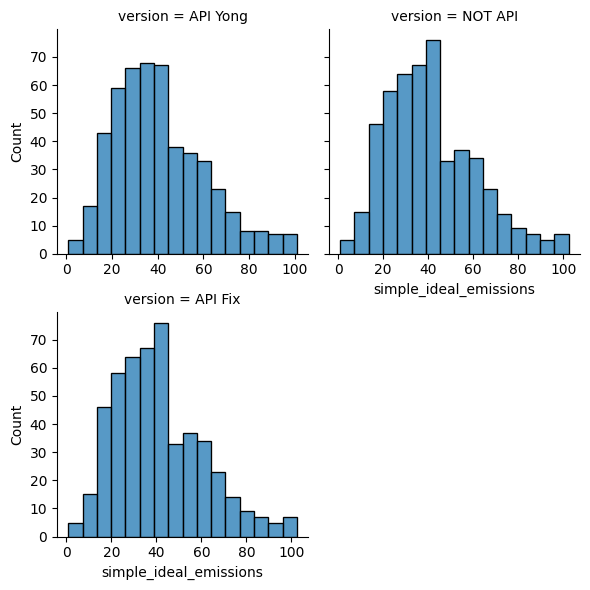

In [27]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=2)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "simple_ideal_emissions")

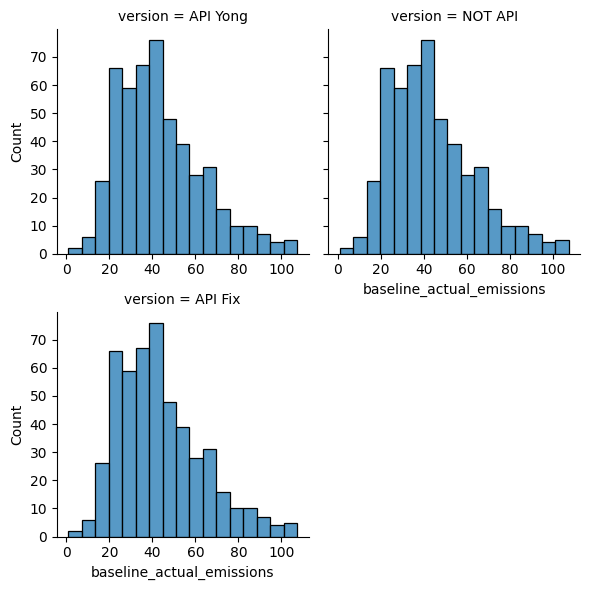

In [28]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=2)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "baseline_actual_emissions")

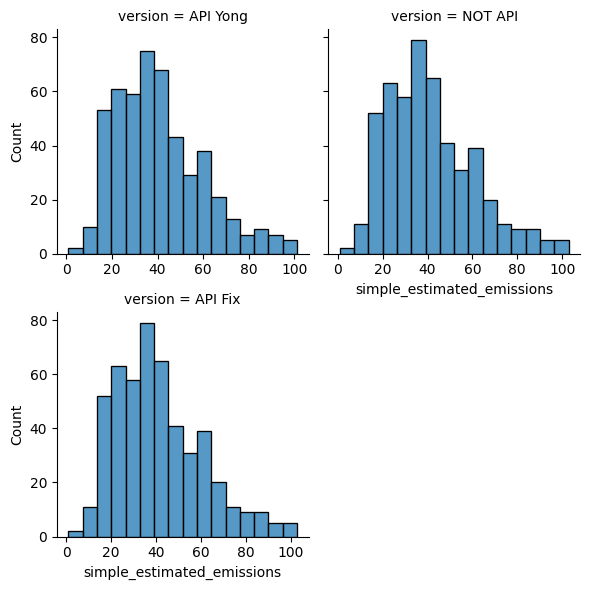

In [29]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=2)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "simple_estimated_emissions")

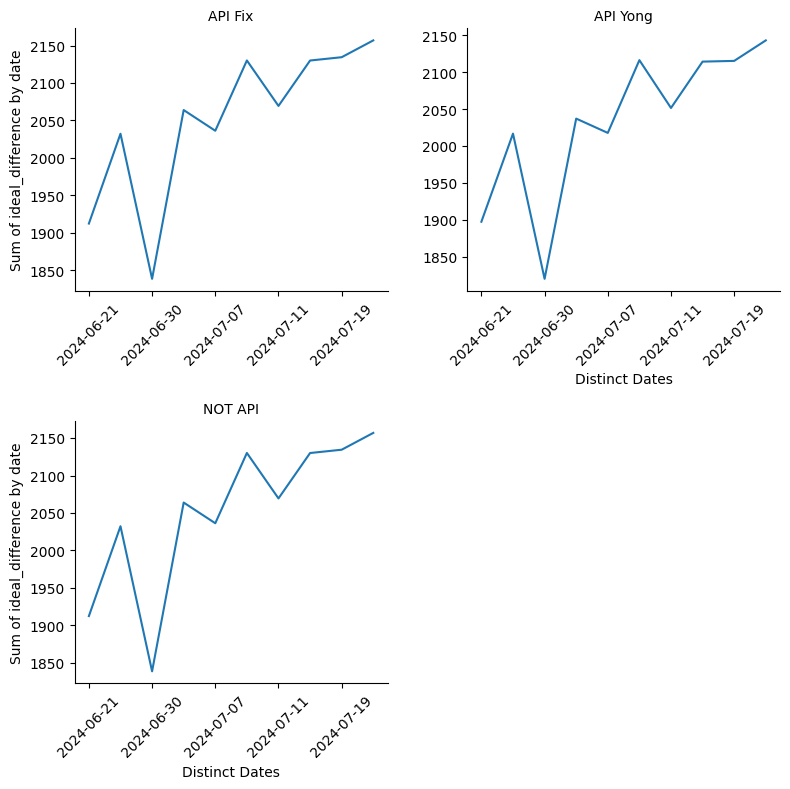

In [30]:
grouped_data = results_data.groupby(['distinct_dates', 'version'])['simple_estimated_emissions'].sum().reset_index()
g = sns.FacetGrid(grouped_data, col='version', col_wrap=2, sharex=False, sharey=False, height=4, aspect=1)

def plot_sum(data, **kwargs):
    ax = sns.lineplot(data=data, x='distinct_dates', y='simple_estimated_emissions', **kwargs)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::max(1, len(xticks) // 4)])  # Reduce the number of xticks to a maximum of 4
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
g.map_dataframe(plot_sum)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Distinct Dates", "Sum of ideal_difference by date")
plt.show()


In [31]:
results_data.groupby('version')[['simple_actual_emissions', 'baseline_actual_emissions',
       'simple_estimated_emissions', 'simple_ideal_emissions']].sum()

,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions
version,,,,
API Fix,20856.950553,21736.541587,20504.312689,20578.300724
API Yong,20684.434022,21736.541587,20330.827781,20324.053184
NOT API,20856.950553,21736.541587,20504.312689,20578.300724
